### Simple 1D example of `Hilbert DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
    plot_ddpm_1d_result,
    get_hbm_M,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
# plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'mps' # mps, cpu
model = DiffusionUNet(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_model_channels     = 64,
    n_emb_dim            = 256,
    n_enc_blocks         = 2, # number of encoder blocks
    n_dec_blocks         = 2, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 5, # kernel size (3)
    padding              = 2, # padding size (1)
    use_resblock         = True,
    use_attention        = True,
    skip_connection      = True, # additional skip connection
    use_scale_shift_norm = True, 
    device               = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

In [4]:
times,x_0 = get_1d_training_data(
    traj_type = 'gp', # gp / step / step2
    n_traj    = 2,
    L         = 100,
    device    = device,
    seed      = 0,
    plot_data = False,
    verbose   = True
    )

x_0:[2x1x100]


In [5]:
M_list = []
M_list.append(
    th.from_numpy(np.eye(len(times))).to(th.float32).to(device)
)
for hyp_len in [1.0,0.1,0.01,0.001]:
    M = get_hbm_M(times,hyp_gain=1.0,hyp_len=0.1,device=device) # [L x L]
    M_list.append(M)
# M = None
print ("Hilbert Brownian motion ready.")

Hilbert Brownian motion ready.


### Train

it:[      0][0.0]% loss:[2.5538]


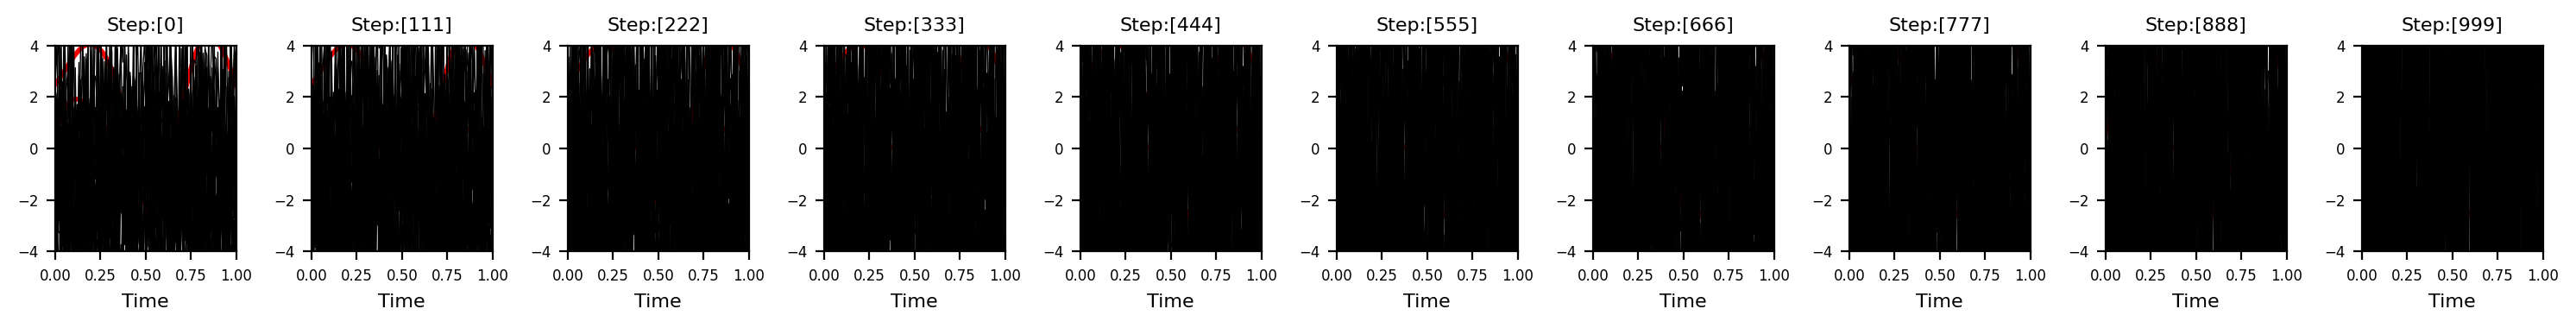

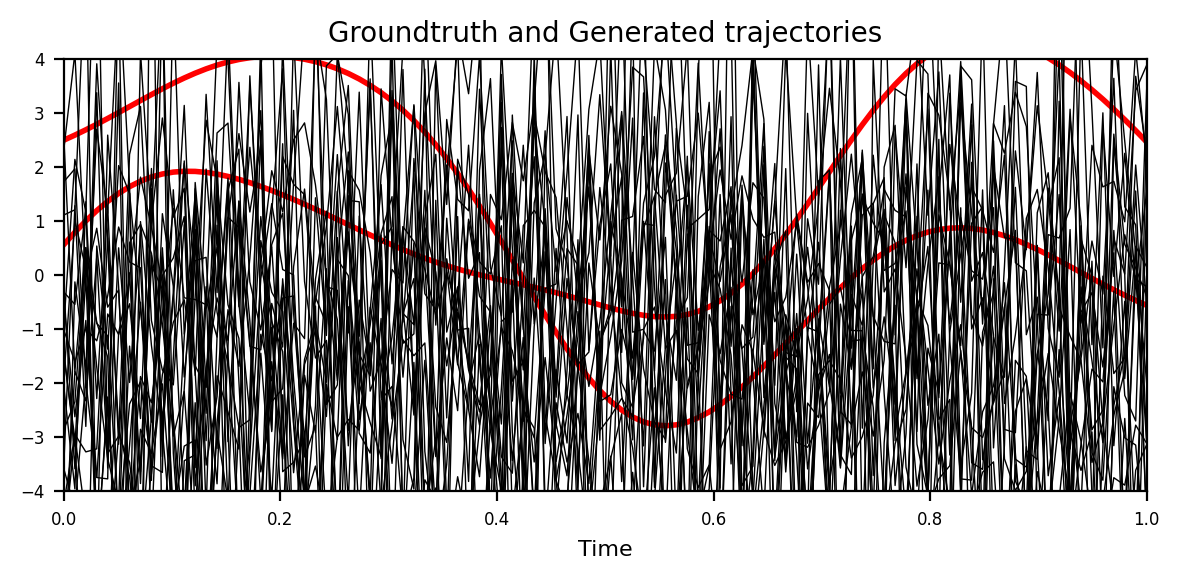

it:[   1000][5.0]% loss:[0.5815]
it:[   2000][10.0]% loss:[0.5071]
it:[   3000][15.0]% loss:[0.4104]
it:[   4000][20.0]% loss:[0.3808]
it:[   5000][25.0]% loss:[0.1813]


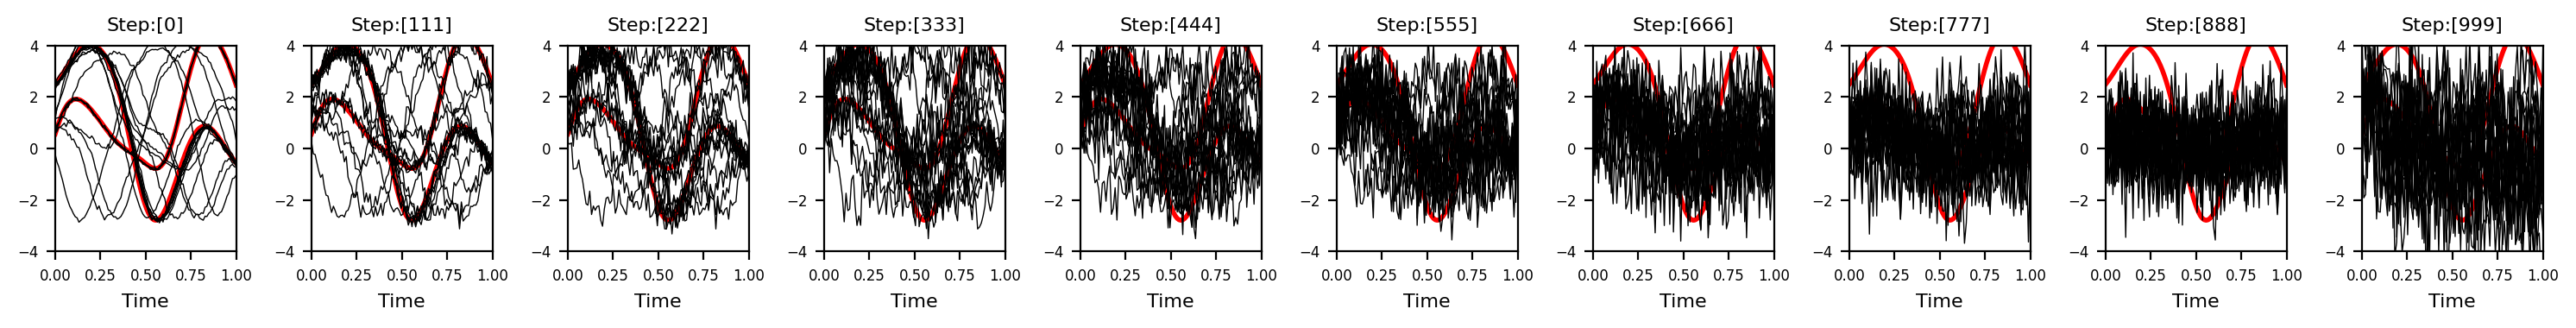

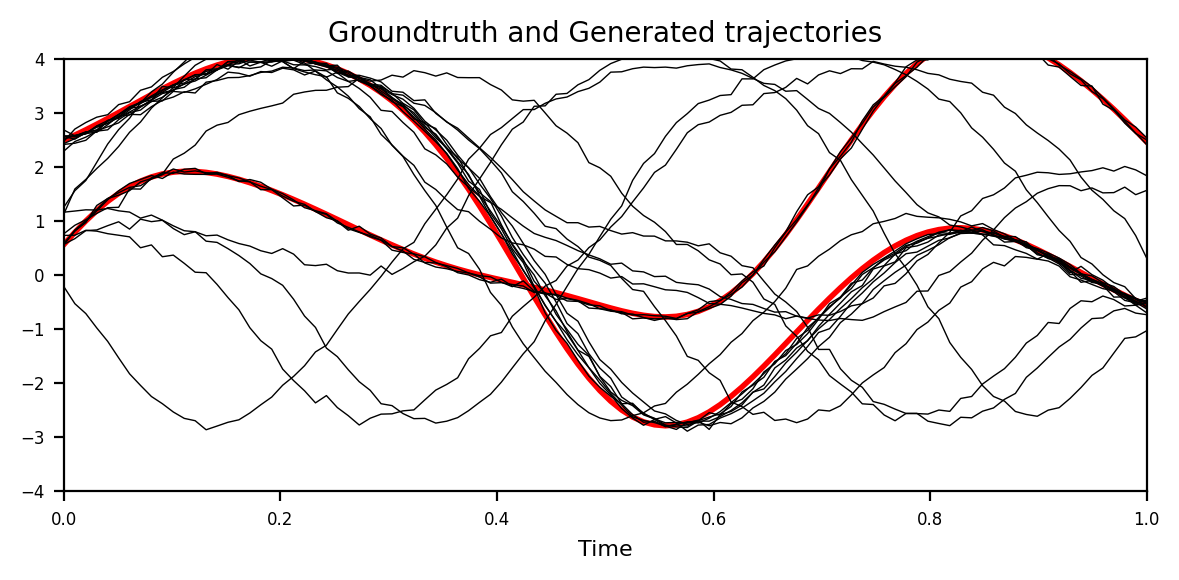

it:[   6000][30.0]% loss:[0.4411]
it:[   7000][35.0]% loss:[0.2942]
it:[   8000][40.0]% loss:[0.2772]
it:[   9000][45.0]% loss:[0.2183]
it:[  10000][50.0]% loss:[0.2040]


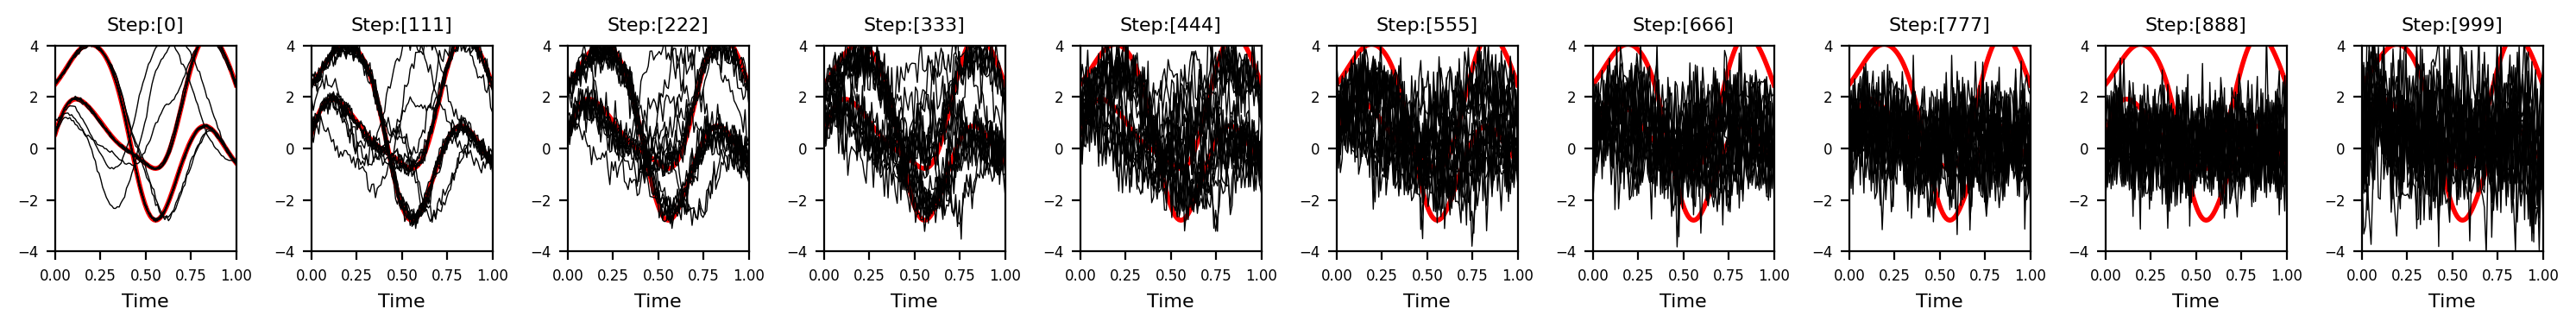

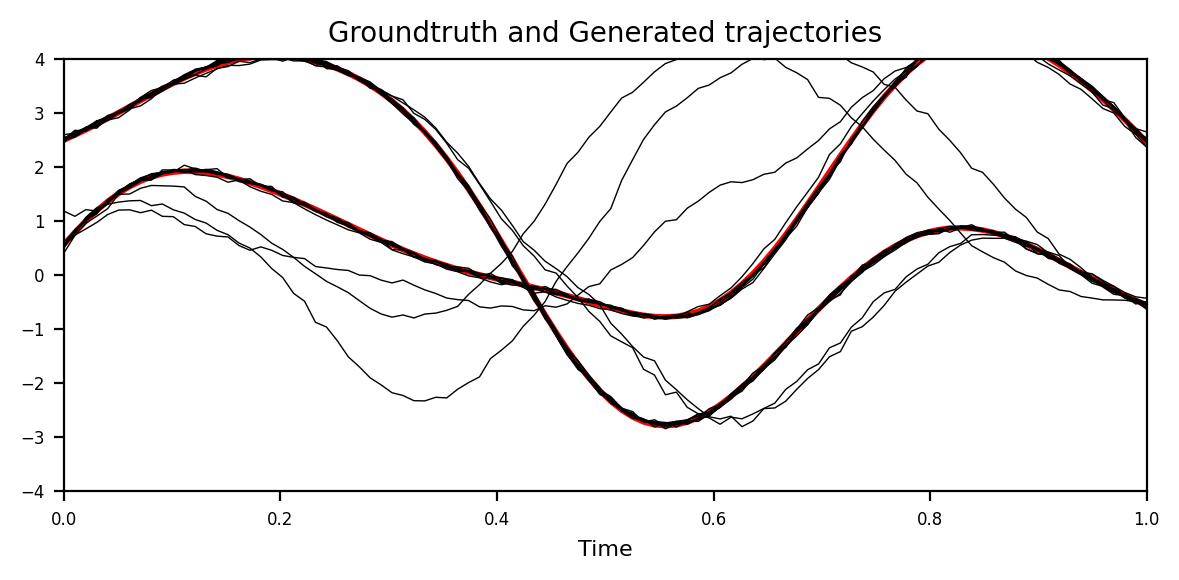

it:[  11000][55.0]% loss:[0.2686]
it:[  12000][60.0]% loss:[0.2813]
it:[  13000][65.0]% loss:[0.1357]
it:[  14000][70.0]% loss:[0.2232]
it:[  15000][75.0]% loss:[0.2255]


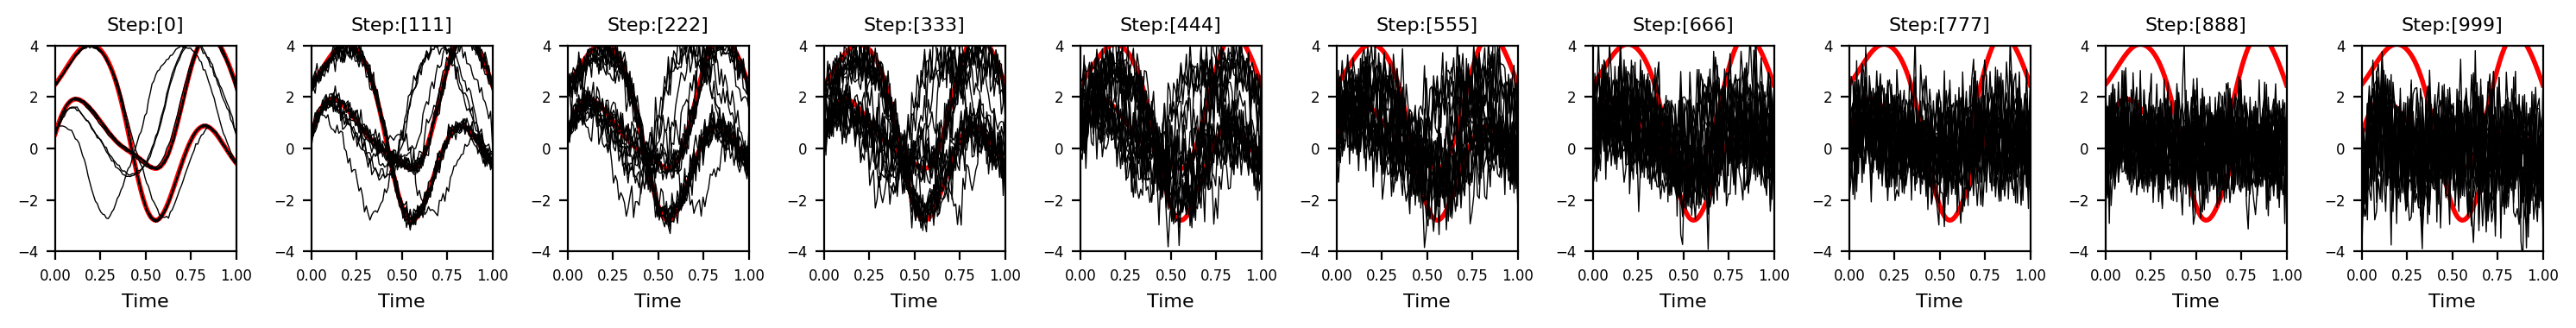

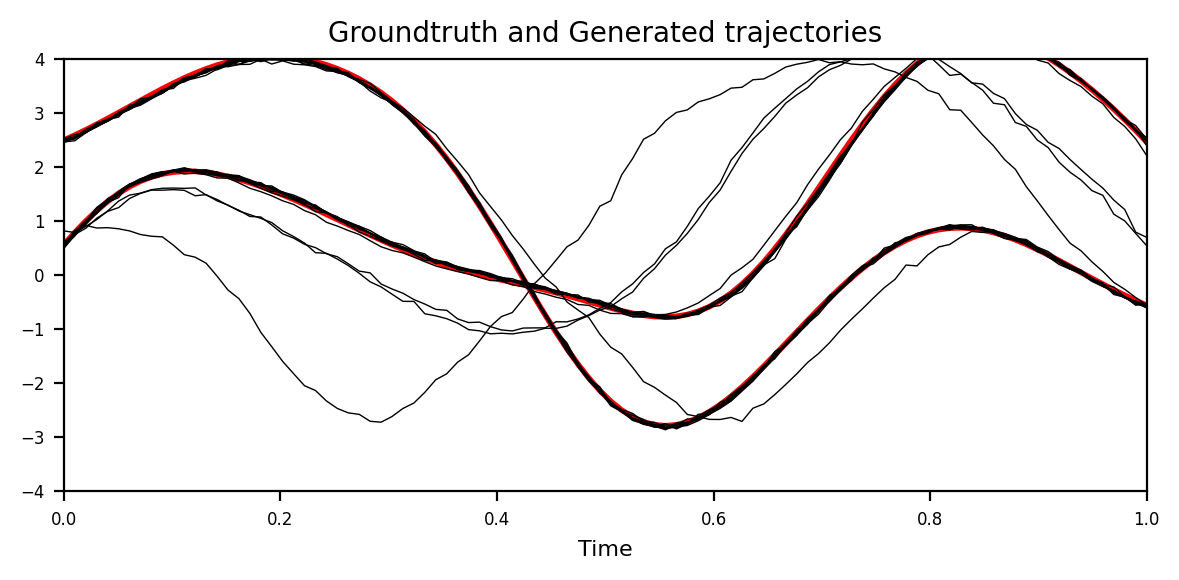

it:[  16000][80.0]% loss:[0.1880]
it:[  17000][85.0]% loss:[0.1527]
it:[  18000][90.0]% loss:[0.1990]
it:[  19000][95.0]% loss:[0.1889]
it:[  19999][100.0]% loss:[0.2270]


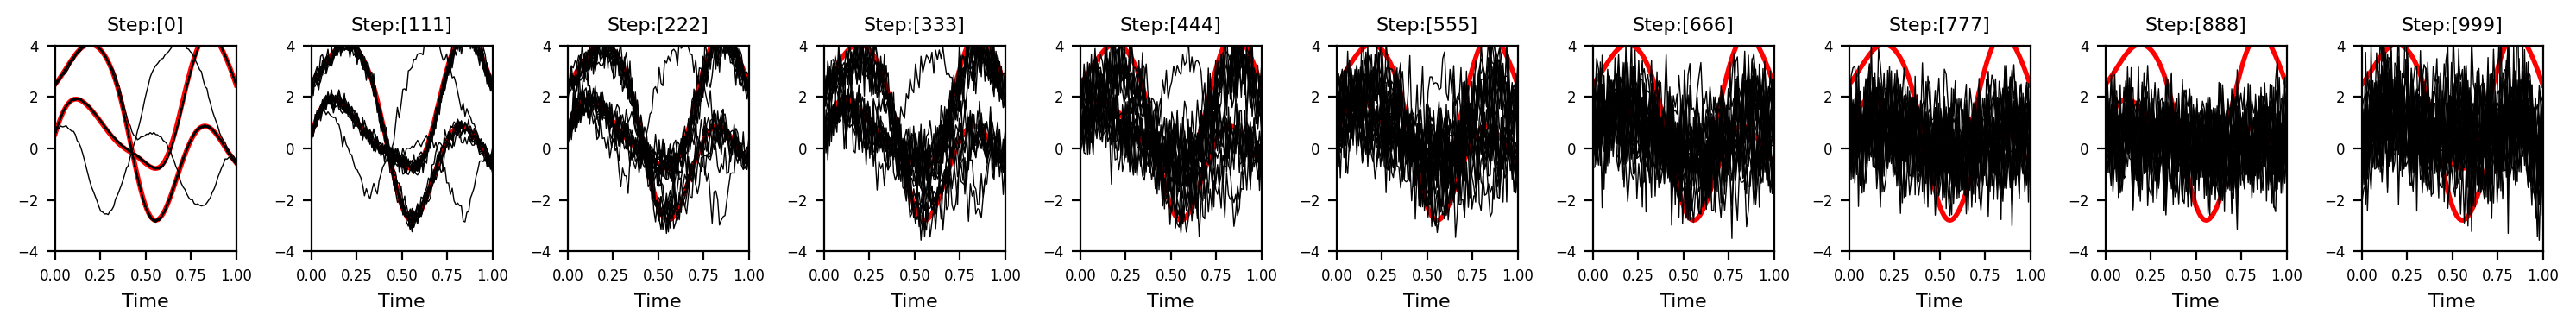

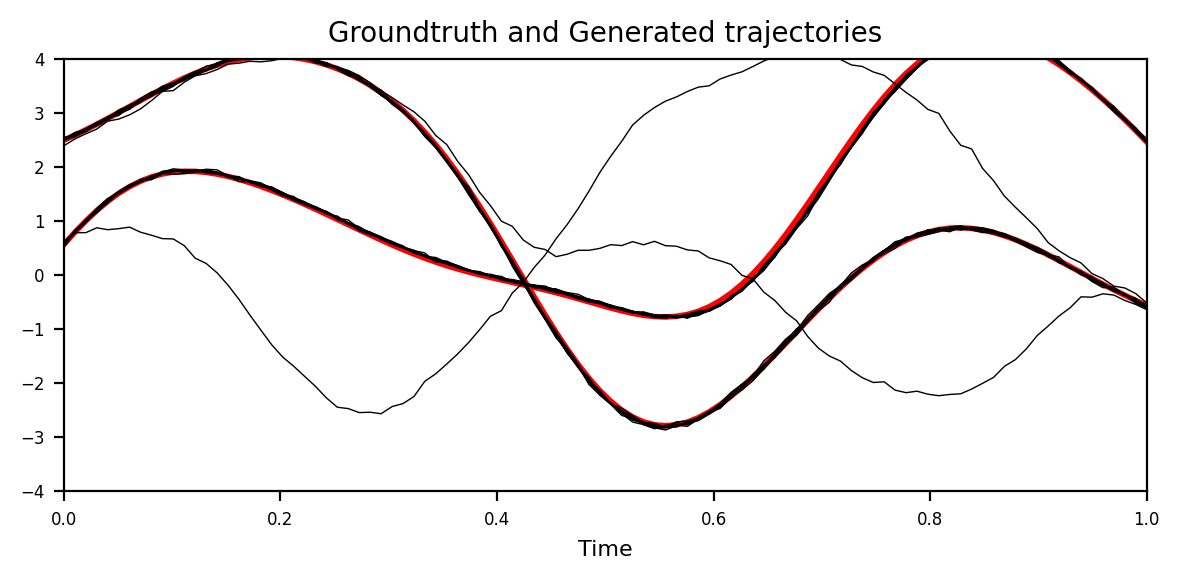

Done.


In [6]:
# Configuration
max_iter    = int(2e4)
batch_size  = 128
print_every = 1e3
eval_every  = 5e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc,M_list) # [B x C x L]

    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        M = None
        x_t_list = eval_ddpm_1d(
            model,dc,n_sample,x_0,step_list_to_append,device,M)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=False,
            plot_one_sample=False,lw_gt=2,lw_sample=1/2,lc_gt='r',lc_sample='k',
            ylim=(-4,+4),figsize=(6,3),title_str=None
        )

print ("Done.")

### Evaluate

In [7]:
n_sample = 100
step_list_to_append = np.linspace(0,999,10).astype(np.int64)
x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device,M)
print ("Sampling [%d] trajectories done."%(n_sample))

Sampling [100] trajectories done.


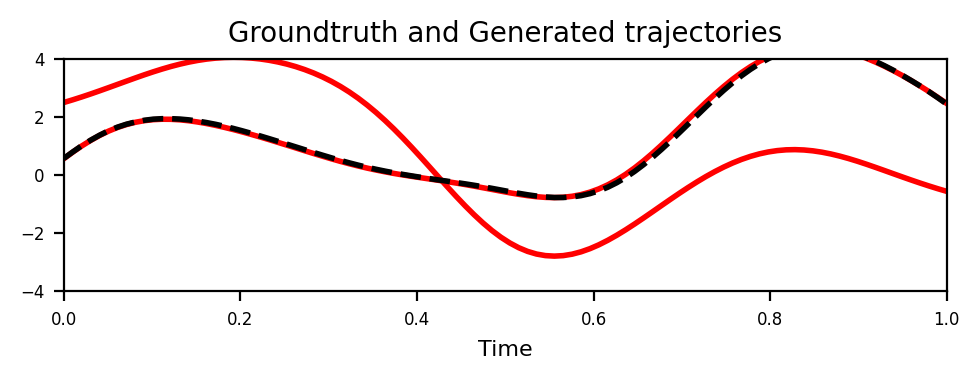

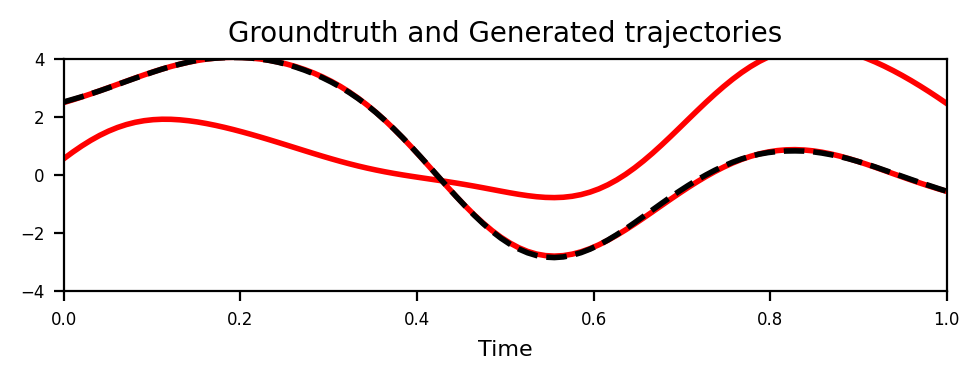

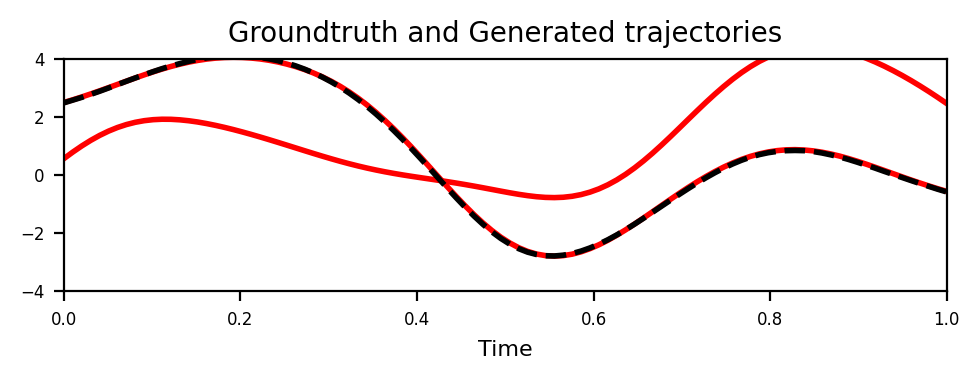

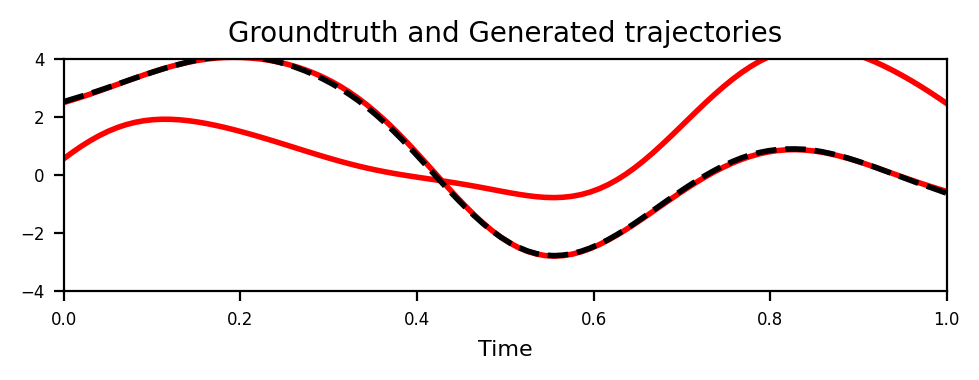

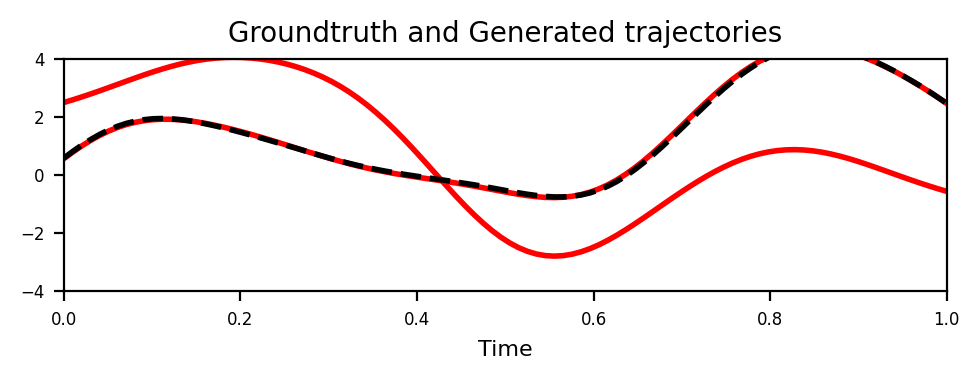

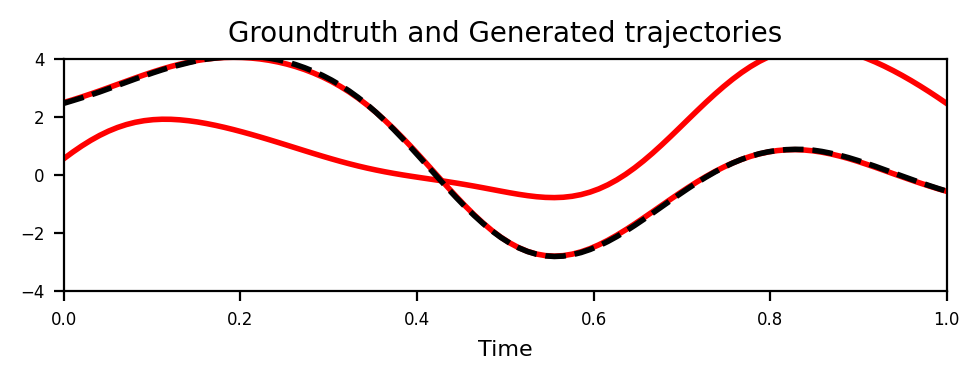

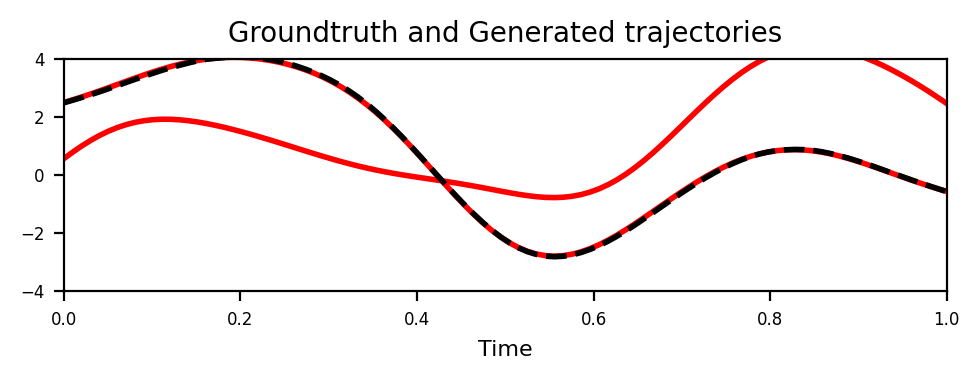

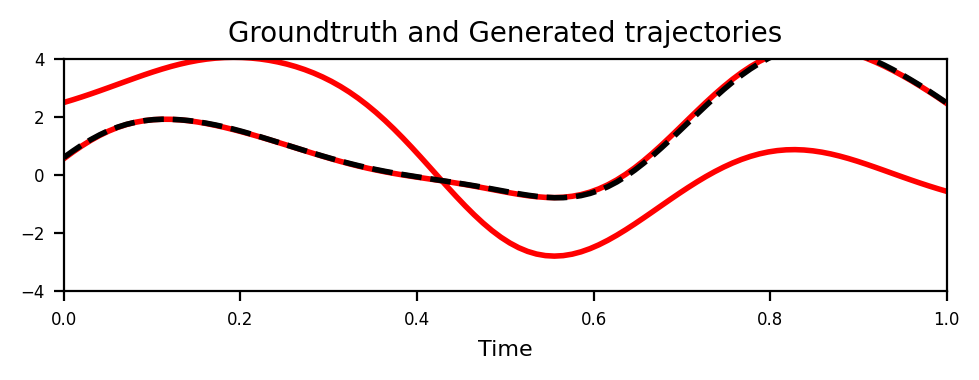

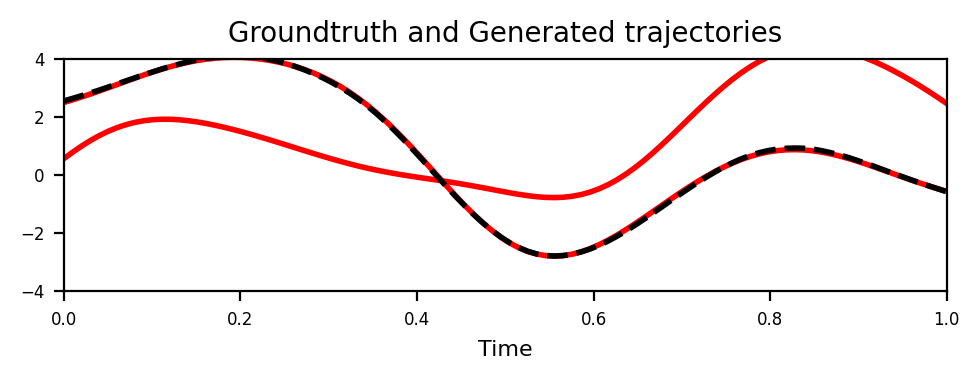

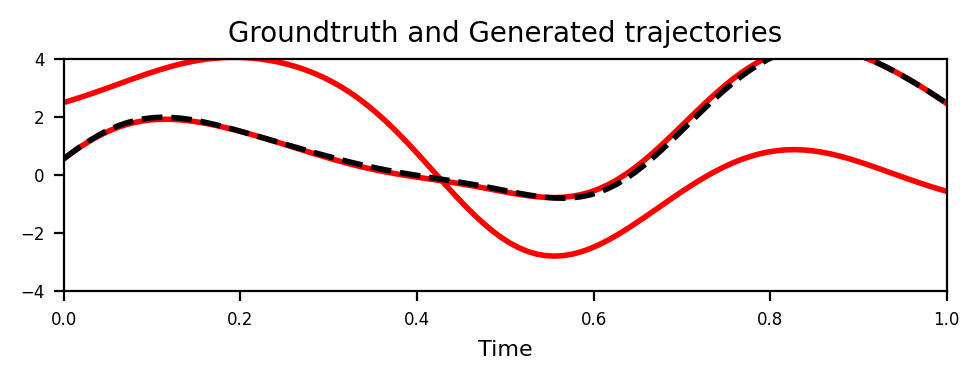

In [8]:
for _ in range(10):
    plot_ddpm_1d_result(
        times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
        plot_ancestral_sampling=False,plot_one_sample=True,
        lw_gt=2,lw_sample=2,ls_gt='-',ls_sample='--',lc_gt='r',lc_sample='k',ylim=(-4,+4),
        figsize=(5,2)
    )